In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.chdir('../../')
os.getcwd()

'/home/bunny/projects/IConNet'

In [5]:
dataset_name = 'iemocap'
experiment_prefix = "scb14"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"

sr = 16000
batch_size = 2
in_channels = 1
kernel_size = 511
stride = 125
embedding_dim = 511
num_embeddings = 384
cls_dim = 512
learning_rate = 1e-4
max_num_tokens = 2048
num_classes = 4
commitment_cost = 0.1

In [6]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB14 as SCB
from omegaconf import OmegaConf as ocf

In [7]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [8]:
dataset_config_path = f'config/dataset/{dataset_name}4.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)
print(batch_size)

{'name': 'iemocap', 'dataset_class': 'WaveformDataset', 'root': 'iemocap/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label4', 'feature_name': 'audio16k', 'num_classes': 4, 'label_values': ['neu', 'hap', 'sad', 'ang'], 'classnames': ['neu', 'hap', 'sad', 'ang'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}
2


In [9]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0, loss_recon=0, loss_cls=1)

trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=8)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [10]:
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=512,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='minami',
    iconnet_config=iconnet_config,
)

In [11]:
trainer.setup(model=model, lr=learning_rate)

In [12]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▏                                                  | 0.476833976833989/100 [06:45<715:43:12, 25889.38s/it]

Epoch: 1	Loss: 1.116 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.116]	Val_acc: 84/197 (42.64%)

Saved new best val model: ../scb14_models/iemocap/model.epoch=1.step=864.loss=1.116.val_acc=0.426.pt


  1%|▊                                                    | 1.4295366795367364/100 [17:42<16:57:50, 619.56s/it]

Correct: 388/988 (0.3927)
Saved new best test model: ../scb14_models/iemocap/model.epoch=1.step=1727.test_acc=0.3927.pt
{'acc_unweighted': tensor(0.4425, device='cuda:0'),
 'acc_weighted': tensor(0.3927, device='cuda:0'),
 'f1s_unweighted': tensor(0.2767, device='cuda:0'),
 'f1s_weighted': tensor(0.2458, device='cuda:0'),
 'rocauc': tensor(0.7574, device='cuda:0'),
 'uar': tensor(0.4425, device='cuda:0'),
 'wap': tensor(0.5246, device='cuda:0')}
{'acc_detail': tensor([0.8869, 0.0029, 0.8802, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.4906, 0.0058, 0.6102, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.3391, 1.0000, 0.4670, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.8869, 0.0029, 0.8802, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.8096, 0.6920, 0.8755, 0.6525], device='cuda:0')}
tensor([[196,   0,  25,   0],
        [174,   1, 167,   0],
        [ 26,   0, 191,   0],
        [182,   0,  26,   0]], device='cuda:0')


  2%|▉                                                 | 1.9063706563707945/100 [24:30<717:11:28, 26320.65s/it]

Epoch: 2	Loss: 4.435 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=4.435]	Val_acc: 93/197 (47.21%)

Saved new best val model: ../scb14_models/iemocap/model.epoch=2.step=2591.loss=4.435.val_acc=0.472.pt


  3%|█▍                                                | 2.8590733590736597/100 [37:24<714:07:34, 26465.21s/it]

Epoch: 3	Loss: 0.646 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.646]	Val_acc: 100/197 (50.76%)

Saved new best val model: ../scb14_models/iemocap/model.epoch=3.step=4318.loss=0.646.val_acc=0.508.pt


  4%|█▉                                                 | 3.811776061776525/100 [50:19<707:12:32, 26468.44s/it]

Epoch: 4	Loss: 2.019 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.019]	Val_acc: 96/197 (48.73%)



  5%|██▍                                               | 4.76447876447939/100 [1:03:16<705:59:31, 26687.22s/it]

Epoch: 5	Loss: 0.491 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.491]	Val_acc: 111/197 (56.35%)

Saved new best val model: ../scb14_models/iemocap/model.epoch=5.step=7772.loss=0.491.val_acc=0.563.pt


  6%|██▊                                              | 5.717181467182255/100 [1:16:22<698:15:56, 26661.87s/it]

Epoch: 6	Loss: 1.136 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.136]	Val_acc: 91/197 (46.19%)



  7%|███▎                                              | 6.66988416988512/100 [1:29:23<695:20:54, 26821.51s/it]

Epoch: 7	Loss: 0.732 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.732]	Val_acc: 106/197 (53.81%)



  8%|███▋                                             | 7.622586872587985/100 [1:42:29<690:58:31, 26927.70s/it]

Epoch: 8	Loss: 0.613 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.613]	Val_acc: 108/197 (54.82%)



  9%|████▎                                             | 8.57528957529085/100 [1:55:38<683:30:11, 26914.08s/it]

Epoch: 9	Loss: 0.720 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.720]	Val_acc: 113/197 (57.36%)

Saved new best val model: ../scb14_models/iemocap/model.epoch=9.step=14680.loss=0.720.val_acc=0.574.pt


 10%|████▋                                            | 9.527992277993715/100 [2:08:50<676:09:14, 26905.06s/it]

Epoch: 10	Loss: 3.071 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=3.071]	Val_acc: 110/197 (55.84%)



 10%|█████▏                                           | 10.48069498069658/100 [2:22:02<670:32:49, 26965.91s/it]

Epoch: 11	Loss: 0.474 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.474]	Val_acc: 116/197 (58.88%)

Saved new best val model: ../scb14_models/iemocap/model.epoch=11.step=18134.loss=0.474.val_acc=0.589.pt


 11%|█████▊                                             | 11.433397683399445/100 [2:33:28<15:56:53, 648.25s/it]

Correct: 549/988 (0.5557)
Saved new best test model: ../scb14_models/iemocap/model.epoch=11.step=18997.test_acc=0.5557.pt
{'acc_unweighted': tensor(0.5417, device='cuda:0'),
 'acc_weighted': tensor(0.5557, device='cuda:0'),
 'f1s_unweighted': tensor(0.5455, device='cuda:0'),
 'f1s_weighted': tensor(0.5511, device='cuda:0'),
 'rocauc': tensor(0.8229, device='cuda:0'),
 'uar': tensor(0.5417, device='cuda:0'),
 'wap': tensor(0.5714, device='cuda:0')}
{'acc_detail': tensor([0.4118, 0.6462, 0.7051, 0.4038], device='cuda:0'),
 'f1s_detail': tensor([0.5260, 0.5808, 0.6623, 0.4128], device='cuda:0'),
 'precision_detail': tensor([0.7280, 0.5274, 0.6245, 0.4221], device='cuda:0'),
 'recall_detail': tensor([0.4118, 0.6462, 0.7051, 0.4038], device='cuda:0'),
 'rocauc_detail': tensor([0.8650, 0.7671, 0.8968, 0.7628], device='cuda:0')}
tensor([[ 91,  49,   6,  75],
        [  5, 221,  80,  36],
        [  0,  60, 153,   4],
        [ 29,  89,   6,  84]], device='cuda:0')


 12%|█████▋                                          | 11.910231660233503/100 [2:40:29<656:05:39, 26812.87s/it]

Epoch: 12	Loss: 0.859 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.859]	Val_acc: 107/197 (54.31%)



 13%|██████▏                                         | 12.862934362936368/100 [2:53:45<656:07:01, 27106.97s/it]

Epoch: 13	Loss: 0.656 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.656]	Val_acc: 112/197 (56.85%)



 14%|██████▋                                         | 13.815637065639233/100 [3:07:08<646:27:27, 27003.13s/it]

Epoch: 14	Loss: 0.774 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.774]	Val_acc: 118/197 (59.90%)

Saved new best val model: ../scb14_models/iemocap/model.epoch=14.step=23315.loss=0.774.val_acc=0.599.pt


 15%|███████                                         | 14.768339768342098/100 [3:20:30<646:14:14, 27295.66s/it]

Epoch: 15	Loss: 0.954 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.954]	Val_acc: 115/197 (58.38%)



 16%|███████▌                                        | 15.721042471044964/100 [3:33:53<639:41:59, 27324.96s/it]

Epoch: 16	Loss: 1.696 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.696]	Val_acc: 109/197 (55.33%)



 17%|████████▏                                        | 16.67374517374783/100 [3:47:17<634:34:24, 27415.91s/it]

Epoch: 17	Loss: 0.564 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.564]	Val_acc: 102/197 (51.78%)



 18%|████████▍                                       | 17.626447876450694/100 [4:00:47<628:11:43, 27454.25s/it]

Epoch: 18	Loss: 0.074 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.074]	Val_acc: 113/197 (57.36%)



 19%|█████████                                        | 18.57915057915356/100 [4:14:20<624:05:05, 27593.74s/it]

Epoch: 19	Loss: 2.047 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.047]	Val_acc: 122/197 (61.93%)

Saved new best val model: ../scb14_models/iemocap/model.epoch=19.step=31950.loss=2.047.val_acc=0.619.pt


 20%|█████████▍                                      | 19.531853281856424/100 [4:27:54<614:27:06, 27489.47s/it]

Epoch: 20	Loss: 0.218 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.218]	Val_acc: 114/197 (57.87%)



 20%|██████████                                       | 20.48455598455929/100 [4:41:34<614:05:44, 27802.71s/it]

Epoch: 21	Loss: 0.199 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.199]	Val_acc: 127/197 (64.47%)

Saved new best val model: ../scb14_models/iemocap/model.epoch=21.step=35404.loss=0.199.val_acc=0.645.pt


 21%|██████████▉                                        | 21.437258687262155/100 [4:53:23<14:39:56, 672.03s/it]

Correct: 567/988 (0.5739)
Saved new best test model: ../scb14_models/iemocap/model.epoch=21.step=36267.test_acc=0.5739.pt
{'acc_unweighted': tensor(0.5602, device='cuda:0'),
 'acc_weighted': tensor(0.5739, device='cuda:0'),
 'f1s_unweighted': tensor(0.5560, device='cuda:0'),
 'f1s_weighted': tensor(0.5635, device='cuda:0'),
 'rocauc': tensor(0.8045, device='cuda:0'),
 'uar': tensor(0.5602, device='cuda:0'),
 'wap': tensor(0.5688, device='cuda:0')}
{'acc_detail': tensor([0.7240, 0.6433, 0.5853, 0.2885], device='cuda:0'),
 'f1s_detail': tensor([0.6426, 0.5978, 0.6287, 0.3550], device='cuda:0'),
 'precision_detail': tensor([0.5776, 0.5584, 0.6791, 0.4615], device='cuda:0'),
 'recall_detail': tensor([0.7240, 0.6433, 0.5853, 0.2885], device='cuda:0'),
 'rocauc_detail': tensor([0.8557, 0.7520, 0.8911, 0.7193], device='cuda:0')}
tensor([[160,  30,   7,  24],
        [ 36, 220,  48,  38],
        [  7,  75, 127,   8],
        [ 74,  69,   5,  60]], device='cuda:0')


 22%|██████████▌                                     | 21.914092664096213/100 [5:00:37<611:17:31, 28182.45s/it]

Epoch: 22	Loss: 0.905 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.905]	Val_acc: 116/197 (58.88%)



 23%|██████████▉                                     | 22.866795366799078/100 [5:14:23<599:07:23, 27962.58s/it]

Epoch: 23	Loss: 0.717 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.717]	Val_acc: 102/197 (51.78%)



 24%|███████████▍                                    | 23.819498069501943/100 [5:28:08<596:33:48, 28191.32s/it]

Epoch: 24	Loss: 0.086 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.086]	Val_acc: 111/197 (56.35%)



 25%|████████████▏                                    | 24.77220077220481/100 [5:41:58<589:27:48, 28208.56s/it]

Epoch: 25	Loss: 0.020 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.020]	Val_acc: 116/197 (58.88%)



 26%|████████████▎                                   | 25.724903474907673/100 [5:55:50<582:54:20, 28252.55s/it]

Epoch: 26	Loss: 0.285 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.285]	Val_acc: 116/197 (58.88%)



 27%|█████████████                                    | 26.67760617761054/100 [6:09:45<577:29:51, 28354.11s/it]

Epoch: 27	Loss: 0.015 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.015]	Val_acc: 116/197 (58.88%)



 28%|█████████████▎                                  | 27.630308880313404/100 [6:23:43<569:43:39, 28340.86s/it]

Epoch: 28	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 124/197 (62.94%)



 29%|██████████████                                   | 28.58301158301627/100 [6:37:43<566:40:50, 28565.34s/it]

Epoch: 29	Loss: 0.107 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.107]	Val_acc: 115/197 (58.38%)



 30%|██████████████▏                                 | 29.535714285719134/100 [6:51:46<558:07:13, 28514.21s/it]

Epoch: 30	Loss: 0.290 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.290]	Val_acc: 102/197 (51.78%)



 30%|███████████████▌                                   | 30.488416988422/100 [7:05:53<555:35:53, 28774.39s/it]

Epoch: 31	Loss: 0.020 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.020]	Val_acc: 115/197 (58.38%)



 31%|████████████████                                   | 31.441119691124864/100 [7:18:06<13:16:16, 696.87s/it]

Correct: 517/988 (0.5233)
{'acc_unweighted': tensor(0.5518, device='cuda:0'),
 'acc_weighted': tensor(0.5233, device='cuda:0'),
 'f1s_unweighted': tensor(0.5280, device='cuda:0'),
 'f1s_weighted': tensor(0.5151, device='cuda:0'),
 'rocauc': tensor(0.7945, device='cuda:0'),
 'uar': tensor(0.5518, device='cuda:0'),
 'wap': tensor(0.5451, device='cuda:0')}
{'acc_detail': tensor([0.5928, 0.3246, 0.7465, 0.5433], device='cuda:0'),
 'f1s_detail': tensor([0.6107, 0.4173, 0.6391, 0.4449], device='cuda:0'),
 'precision_detail': tensor([0.6298, 0.5842, 0.5586, 0.3767], device='cuda:0'),
 'recall_detail': tensor([0.5928, 0.3246, 0.7465, 0.5433], device='cuda:0'),
 'rocauc_detail': tensor([0.8340, 0.7411, 0.8737, 0.7292], device='cuda:0')}
tensor([[131,  16,  15,  59],
        [ 23, 111, 101, 107],
        [  7,  27, 162,  21],
        [ 47,  36,  12, 113]], device='cuda:0')


 32%|███████████████▎                                | 31.917953667958923/100 [7:25:35<544:29:18, 28791.13s/it]

Epoch: 32	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 110/197 (55.84%)



 33%|███████████████▊                                | 32.870656370661784/100 [7:39:44<539:52:54, 28952.68s/it]

Epoch: 33	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 110/197 (55.84%)



 34%|████████████████▌                                | 33.82335907336465/100 [7:53:58<535:24:11, 29125.86s/it]

Epoch: 34	Loss: 0.051 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.051]	Val_acc: 106/197 (53.81%)



 35%|████████████████▋                               | 34.776061776067515/100 [8:08:15<528:16:01, 29157.42s/it]

Epoch: 35	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 110/197 (55.84%)



 36%|█████████████████▌                               | 35.72876447877038/100 [8:22:33<519:42:58, 29110.67s/it]

Epoch: 36	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 111/197 (56.35%)



 37%|█████████████████▌                              | 36.681467181473245/100 [8:36:55<515:03:55, 29284.25s/it]

Epoch: 37	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 107/197 (54.31%)



 38%|██████████████████▍                              | 37.63416988417611/100 [8:51:19<508:48:52, 29370.77s/it]

Epoch: 38	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 104/197 (52.79%)



 39%|██████████████████▌                             | 38.586872586878975/100 [9:05:46<502:04:06, 29430.94s/it]

Epoch: 39	Loss: 0.009 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.009]	Val_acc: 105/197 (53.30%)



 40%|███████████████████▎                             | 39.53957528958184/100 [9:20:17<495:37:11, 29510.73s/it]

Epoch: 40	Loss: 0.196 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.196]	Val_acc: 112/197 (56.85%)



 40%|███████████████████▍                            | 40.492277992284706/100 [9:34:47<489:42:57, 29626.02s/it]

Epoch: 41	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 110/197 (55.84%)



 41%|█████████████████████▌                              | 41.44498069498757/100 [9:47:30<11:47:11, 724.64s/it]

Correct: 510/988 (0.5162)
{'acc_unweighted': tensor(0.5050, device='cuda:0'),
 'acc_weighted': tensor(0.5162, device='cuda:0'),
 'f1s_unweighted': tensor(0.5082, device='cuda:0'),
 'f1s_weighted': tensor(0.5136, device='cuda:0'),
 'rocauc': tensor(0.7729, device='cuda:0'),
 'uar': tensor(0.5050, device='cuda:0'),
 'wap': tensor(0.5523, device='cuda:0')}
{'acc_detail': tensor([0.6018, 0.5906, 0.3226, 0.5048], device='cuda:0'),
 'f1s_detail': tensor([0.6018, 0.5430, 0.4487, 0.4393], device='cuda:0'),
 'precision_detail': tensor([0.6018, 0.5025, 0.7368, 0.3889], device='cuda:0'),
 'recall_detail': tensor([0.6018, 0.5906, 0.3226, 0.5048], device='cuda:0'),
 'rocauc_detail': tensor([0.8202, 0.7208, 0.8439, 0.7068], device='cuda:0')}
tensor([[133,  29,   3,  56],
        [ 26, 202,  21,  93],
        [ 10, 121,  70,  16],
        [ 52,  50,   1, 105]], device='cuda:0')


 42%|████████████████████▌                            | 41.92181467182163/100 [9:55:13<475:44:06, 29488.64s/it]

Epoch: 42	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 108/197 (54.82%)



 43%|████████████████████▏                          | 42.874517374524494/100 [10:09:52<472:12:27, 29758.13s/it]

Epoch: 43	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 106/197 (53.81%)



 44%|█████████████████████                           | 43.82722007722736/100 [10:24:33<465:27:43, 29830.53s/it]

Epoch: 44	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 105/197 (53.30%)



 45%|█████████████████████                          | 44.779922779930224/100 [10:39:19<457:42:22, 29839.56s/it]

Epoch: 45	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 107/197 (54.31%)



 46%|█████████████████████▉                          | 45.73262548263309/100 [10:54:06<454:30:57, 30151.78s/it]

Epoch: 46	Loss: 0.033 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.033]	Val_acc: 103/197 (52.28%)



 47%|█████████████████████▉                         | 46.685328185335955/100 [11:08:56<448:19:25, 30272.45s/it]

Epoch: 47	Loss: 0.019 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.019]	Val_acc: 107/197 (54.31%)



 48%|██████████████████████▊                         | 47.63803088803882/100 [11:23:50<442:09:55, 30399.84s/it]

Epoch: 48	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 116/197 (58.88%)



 49%|██████████████████████▊                        | 48.590733590741685/100 [11:38:47<432:11:04, 30264.29s/it]

Epoch: 49	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 107/197 (54.31%)



 50%|███████████████████████▊                        | 49.54343629344455/100 [11:53:48<427:57:45, 30534.49s/it]

Epoch: 50	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 111/197 (56.35%)



 50%|███████████████████████▋                       | 50.496138996147415/100 [12:08:50<418:47:24, 30455.09s/it]

Epoch: 51	Loss: 0.335 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.335]	Val_acc: 102/197 (51.78%)



 51%|██████████████████████████▏                        | 51.44884169885028/100 [12:22:00<10:17:12, 762.75s/it]

Correct: 538/988 (0.5445)
{'acc_unweighted': tensor(0.5567, device='cuda:0'),
 'acc_weighted': tensor(0.5445, device='cuda:0'),
 'f1s_unweighted': tensor(0.5467, device='cuda:0'),
 'f1s_weighted': tensor(0.5432, device='cuda:0'),
 'rocauc': tensor(0.7944, device='cuda:0'),
 'uar': tensor(0.5567, device='cuda:0'),
 'wap': tensor(0.5565, device='cuda:0')}
{'acc_detail': tensor([0.5339, 0.4561, 0.7512, 0.4856], device='cuda:0'),
 'f1s_detail': tensor([0.5885, 0.5098, 0.6520, 0.4363], device='cuda:0'),
 'precision_detail': tensor([0.6556, 0.5778, 0.5760, 0.3961], device='cuda:0'),
 'recall_detail': tensor([0.5339, 0.4561, 0.7512, 0.4856], device='cuda:0'),
 'rocauc_detail': tensor([0.8168, 0.7505, 0.8751, 0.7353], device='cuda:0')}
tensor([[118,  29,  12,  62],
        [ 15, 156,  94,  77],
        [  4,  35, 163,  15],
        [ 43,  50,  14, 101]], device='cuda:0')


 52%|████████████████████████▉                       | 51.92567567568434/100 [12:29:57<409:20:54, 30653.68s/it]

Epoch: 52	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 98/197 (49.75%)



 53%|████████████████████████▊                      | 52.878378378387204/100 [12:45:08<402:48:27, 30773.71s/it]

Epoch: 53	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 111/197 (56.35%)



 54%|█████████████████████████▊                      | 53.83108108109007/100 [13:00:16<396:08:11, 30888.56s/it]

Epoch: 54	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 105/197 (53.30%)



 55%|█████████████████████████▋                     | 54.783783783792934/100 [13:15:28<389:11:54, 30987.00s/it]

Epoch: 55	Loss: 0.044 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.044]	Val_acc: 94/197 (47.72%)



 56%|███████████████████████████▎                     | 55.7364864864958/100 [13:30:45<380:47:20, 30969.98s/it]

Epoch: 56	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 103/197 (52.28%)



 57%|██████████████████████████▋                    | 56.689189189198665/100 [13:46:05<375:45:47, 31233.49s/it]

Epoch: 57	Loss: 0.166 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.166]	Val_acc: 111/197 (56.35%)



 58%|███████████████████████████▋                    | 57.64189189190153/100 [14:01:26<366:33:48, 31154.09s/it]

Epoch: 58	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 97/197 (49.24%)



 59%|███████████████████████████▌                   | 58.594594594604395/100 [14:16:49<358:47:13, 31194.80s/it]

Epoch: 59	Loss: 0.072 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.072]	Val_acc: 108/197 (54.82%)



 60%|████████████████████████████▌                   | 59.54729729730726/100 [14:32:17<350:26:45, 31187.17s/it]

Epoch: 60	Loss: 0.534 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.534]	Val_acc: 114/197 (57.87%)



 61%|████████████████████████████▍                  | 60.500000000010125/100 [14:47:45<341:57:54, 31166.45s/it]

Epoch: 61	Loss: 0.108 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.108]	Val_acc: 110/197 (55.84%)



 61%|███████████████████████████████▉                    | 61.45270270271299/100 [15:01:23<8:32:32, 797.79s/it]

Correct: 529/988 (0.5354)
{'acc_unweighted': tensor(0.5471, device='cuda:0'),
 'acc_weighted': tensor(0.5354, device='cuda:0'),
 'f1s_unweighted': tensor(0.5367, device='cuda:0'),
 'f1s_weighted': tensor(0.5337, device='cuda:0'),
 'rocauc': tensor(0.7844, device='cuda:0'),
 'uar': tensor(0.5471, device='cuda:0'),
 'wap': tensor(0.5443, device='cuda:0')}
{'acc_detail': tensor([0.5385, 0.4503, 0.7189, 0.4808], device='cuda:0'),
 'f1s_detail': tensor([0.5749, 0.5049, 0.6265, 0.4405], device='cuda:0'),
 'precision_detail': tensor([0.6166, 0.5746, 0.5552, 0.4065], device='cuda:0'),
 'recall_detail': tensor([0.5385, 0.4503, 0.7189, 0.4808], device='cuda:0'),
 'rocauc_detail': tensor([0.8042, 0.7394, 0.8576, 0.7365], device='cuda:0')}
tensor([[119,  26,  18,  58],
        [ 24, 154,  87,  77],
        [  5,  45, 156,  11],
        [ 45,  43,  20, 100]], device='cuda:0')


 62%|█████████████████████████████▋                  | 61.92953667954705/100 [15:09:36<332:04:21, 31401.30s/it]

Epoch: 62	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 107/197 (54.31%)



 63%|█████████████████████████████▌                 | 62.882239382249914/100 [15:25:11<325:55:48, 31611.51s/it]

Epoch: 63	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 105/197 (53.30%)



 64%|██████████████████████████████▋                 | 63.83494208495278/100 [15:40:52<319:09:11, 31769.67s/it]

Epoch: 64	Loss: 0.063 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.063]	Val_acc: 102/197 (51.78%)



 65%|███████████████████████████████                 | 64.78764478764404/100 [15:56:37<312:03:10, 31903.29s/it]

Epoch: 65	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 106/197 (53.81%)



 66%|███████████████████████████████▌                | 65.74034749033288/100 [16:12:23<301:59:35, 31733.42s/it]

Epoch: 66	Loss: 0.011 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.011]	Val_acc: 105/197 (53.30%)



 67%|████████████████████████████████                | 66.69305019302172/100 [16:28:13<296:52:07, 32087.23s/it]

Epoch: 67	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 102/197 (51.78%)



 68%|████████████████████████████████▍               | 67.64575289571056/100 [16:44:07<290:39:39, 32341.33s/it]

Epoch: 68	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 106/197 (53.81%)



 69%|█████████████████████████████████▌               | 68.5984555983994/100 [17:00:01<282:45:20, 32416.25s/it]

Epoch: 69	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 94/197 (47.72%)



 70%|█████████████████████████████████▍              | 69.55115830108824/100 [17:16:00<274:23:21, 32441.35s/it]

Epoch: 70	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 105/197 (53.30%)



 71%|█████████████████████████████████▊              | 70.50386100377708/100 [17:32:00<265:13:06, 32369.88s/it]

Epoch: 71	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 105/197 (53.30%)



 71%|█████████████████████████████████████▏              | 71.45656370646591/100 [17:46:08<6:32:18, 824.67s/it]

Correct: 549/988 (0.5557)
{'acc_unweighted': tensor(0.5584, device='cuda:0'),
 'acc_weighted': tensor(0.5557, device='cuda:0'),
 'f1s_unweighted': tensor(0.5568, device='cuda:0'),
 'f1s_weighted': tensor(0.5569, device='cuda:0'),
 'rocauc': tensor(0.7957, device='cuda:0'),
 'uar': tensor(0.5584, device='cuda:0'),
 'wap': tensor(0.5595, device='cuda:0')}
{'acc_detail': tensor([0.5747, 0.5292, 0.6728, 0.4567], device='cuda:0'),
 'f1s_detail': tensor([0.5935, 0.5468, 0.6562, 0.4308], device='cuda:0'),
 'precision_detail': tensor([0.6135, 0.5656, 0.6404, 0.4077], device='cuda:0'),
 'recall_detail': tensor([0.5747, 0.5292, 0.6728, 0.4567], device='cuda:0'),
 'rocauc_detail': tensor([0.8252, 0.7459, 0.8702, 0.7413], device='cuda:0')}
tensor([[127,  29,  10,  55],
        [ 23, 181,  63,  75],
        [  8,  55, 146,   8],
        [ 49,  55,   9,  95]], device='cuda:0')


 72%|██████████████████████████████████▌             | 71.93339768329295/100 [17:54:39<255:25:02, 32761.44s/it]

Epoch: 72	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 104/197 (52.79%)



 73%|██████████████████████████████████▉             | 72.88610038598179/100 [18:10:43<246:24:01, 32715.38s/it]

Epoch: 73	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 101/197 (51.27%)



 74%|███████████████████████████████████▍            | 73.83880308867063/100 [18:26:52<234:47:53, 32310.20s/it]

Epoch: 74	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 96/197 (48.73%)



 75%|███████████████████████████████████▉            | 74.79150579135947/100 [18:43:06<227:58:42, 32557.38s/it]

Epoch: 75	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 99/197 (50.25%)



 76%|████████████████████████████████████▎           | 75.74420849404831/100 [18:59:22<220:30:47, 32728.17s/it]

Epoch: 76	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 111/197 (56.35%)



 77%|████████████████████████████████████▊           | 76.69691119673715/100 [19:15:41<211:37:46, 32693.81s/it]

Epoch: 77	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 103/197 (52.28%)



 78%|█████████████████████████████████████▎          | 77.64961389942599/100 [19:32:01<204:39:19, 32964.05s/it]

Epoch: 78	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 111/197 (56.35%)



 79%|█████████████████████████████████████▋          | 78.60231660211483/100 [19:48:26<197:30:07, 33228.26s/it]

Epoch: 79	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 102/197 (51.78%)



 80%|██████████████████████████████████████▏         | 79.55501930480366/100 [20:04:54<189:31:53, 33373.14s/it]

Epoch: 80	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 100/197 (50.76%)



 81%|███████████████████████████████████████▍         | 80.5077220074925/100 [20:21:25<179:17:21, 33112.68s/it]

Epoch: 81	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 108/197 (54.82%)



 81%|██████████████████████████████████████████▎         | 81.46042471018134/100 [20:35:57<4:23:13, 851.85s/it]

Correct: 556/988 (0.5628)
{'acc_unweighted': tensor(0.5646, device='cuda:0'),
 'acc_weighted': tensor(0.5628, device='cuda:0'),
 'f1s_unweighted': tensor(0.5640, device='cuda:0'),
 'f1s_weighted': tensor(0.5642, device='cuda:0'),
 'rocauc': tensor(0.7988, device='cuda:0'),
 'uar': tensor(0.5646, device='cuda:0'),
 'wap': tensor(0.5719, device='cuda:0')}
{'acc_detail': tensor([0.5204, 0.5468, 0.6866, 0.5048], device='cuda:0'),
 'f1s_detail': tensor([0.5838, 0.5574, 0.6535, 0.4615], device='cuda:0'),
 'precision_detail': tensor([0.6647, 0.5684, 0.6234, 0.4251], device='cuda:0'),
 'recall_detail': tensor([0.5204, 0.5468, 0.6866, 0.5048], device='cuda:0'),
 'rocauc_detail': tensor([0.8100, 0.7485, 0.8828, 0.7540], device='cuda:0')}
tensor([[115,  29,  11,  66],
        [ 17, 187,  70,  68],
        [  4,  56, 149,   8],
        [ 37,  57,   9, 105]], device='cuda:0')


 82%|███████████████████████████████████████▎        | 81.93725868700838/100 [20:44:38<166:07:23, 33109.23s/it]

Epoch: 82	Loss: 0.434 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.434]	Val_acc: 94/197 (47.72%)



 83%|███████████████████████████████████████▊        | 82.88996138969722/100 [21:01:14<160:04:53, 33681.63s/it]

Epoch: 83	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 100/197 (50.76%)



 84%|████████████████████████████████████████▏       | 83.84266409238606/100 [21:17:53<151:02:15, 33652.56s/it]

Epoch: 84	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 102/197 (51.78%)



 85%|█████████████████████████████████████████▌       | 84.7953667950749/100 [21:34:33<142:18:37, 33694.82s/it]

Epoch: 85	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 115/197 (58.38%)



 86%|█████████████████████████████████████████▏      | 85.74806949776374/100 [21:51:19<133:15:08, 33659.17s/it]

Epoch: 86	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 109/197 (55.33%)



 87%|█████████████████████████████████████████▌      | 86.70077220045258/100 [22:08:05<125:03:28, 33852.22s/it]

Epoch: 87	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 110/197 (55.84%)



 88%|██████████████████████████████████████████      | 87.65347490314142/100 [22:24:57<116:39:23, 34014.68s/it]

Epoch: 88	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 95/197 (48.22%)



 89%|██████████████████████████████████████████▌     | 88.60617760583025/100 [22:41:51<107:50:33, 34074.04s/it]

Epoch: 89	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 114/197 (57.87%)



 90%|████████████████████████████████████████████▊     | 89.5588803085191/100 [22:58:49<99:08:17, 34181.87s/it]

Epoch: 90	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 107/197 (54.31%)



 91%|████████████████████████████████████████████▎    | 90.51158301120793/100 [23:15:48<90:04:51, 34177.67s/it]

Epoch: 91	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 100/197 (50.76%)



 91%|███████████████████████████████████████████████▌    | 91.46428571389677/100 [23:30:52<2:05:12, 880.13s/it]

Correct: 496/988 (0.5020)
{'acc_unweighted': tensor(0.5326, device='cuda:0'),
 'acc_weighted': tensor(0.5020, device='cuda:0'),
 'f1s_unweighted': tensor(0.5072, device='cuda:0'),
 'f1s_weighted': tensor(0.4954, device='cuda:0'),
 'rocauc': tensor(0.7878, device='cuda:0'),
 'uar': tensor(0.5326, device='cuda:0'),
 'wap': tensor(0.5664, device='cuda:0')}
{'acc_detail': tensor([0.4163, 0.3041, 0.7419, 0.6683], device='cuda:0'),
 'f1s_detail': tensor([0.5111, 0.4094, 0.6598, 0.4484], device='cuda:0'),
 'precision_detail': tensor([0.6619, 0.6265, 0.5941, 0.3374], device='cuda:0'),
 'recall_detail': tensor([0.4163, 0.3041, 0.7419, 0.6683], device='cuda:0'),
 'rocauc_detail': tensor([0.7874, 0.7567, 0.8789, 0.7284], device='cuda:0')}
tensor([[ 92,  11,  14, 104],
        [ 13, 104,  82, 143],
        [  3,  27, 161,  26],
        [ 31,  24,  14, 139]], device='cuda:0')


 92%|█████████████████████████████████████████████    | 91.94111969072381/100 [23:39:52<76:09:10, 34018.47s/it]

Epoch: 92	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 107/197 (54.31%)



 93%|█████████████████████████████████████████████▌   | 92.89382239341265/100 [23:56:53<67:42:34, 34301.76s/it]

Epoch: 93	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 109/197 (55.33%)



 94%|█████████████████████████████████████████████▉   | 93.84652509610149/100 [24:14:02<59:00:44, 34524.25s/it]

Epoch: 94	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 100/197 (50.76%)



 95%|██████████████████████████████████████████████▍  | 94.79922779879033/100 [24:31:14<49:37:42, 34353.13s/it]

Epoch: 95	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 105/197 (53.30%)



 96%|██████████████████████████████████████████████▉  | 95.75193050147917/100 [24:48:27<40:49:36, 34598.50s/it]

Epoch: 96	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 111/197 (56.35%)



 97%|█████████████████████████████████████████████████▎ | 96.704633204168/100 [25:05:42<32:04:11, 35034.60s/it]

Epoch: 97	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 106/197 (53.81%)



 98%|███████████████████████████████████████████████▊ | 97.65733590685684/100 [25:23:06<22:37:47, 34775.46s/it]

Epoch: 98	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 101/197 (51.27%)



 99%|████████████████████████████████████████████████▎| 98.61003860954568/100 [25:40:22<13:30:44, 34996.93s/it]

Epoch: 99	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 105/197 (53.30%)



100%|█████████████████████████████████████████████████▊| 99.56274131223452/100 [25:57:47<4:16:13, 35158.71s/it]

Epoch: 100	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 108/197 (54.82%)



100%|████████████████████████████████████████████████████▉| 99.99999999948685/100 [26:05:22<00:00, 1018.94s/it]/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████████████████████████| 100.03861003809632/100 [26:06:02<-1:59:24, 939.26s/it]


In [13]:
trainer.load_best_model(val_model=True)

Loaded: ../scb14_models/iemocap/model.epoch=21.step=35404.loss=0.199.val_acc=0.645.pt


In [14]:
from pprint import pprint

In [15]:
metrics, metrics_details, confusion_matrix = trainer.test_step()
me = metrics.compute()
med = metrics_details.compute()
cm = confusion_matrix.compute()

Correct: 571/988 (0.5779)
Saved new best test model: ../scb14_models/iemocap/model.epoch=100.step=172700.test_acc=0.5779.pt


In [16]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.5585, device='cuda:0'),
 'acc_weighted': tensor(0.5779, device='cuda:0'),
 'f1s_unweighted': tensor(0.5670, device='cuda:0'),
 'f1s_weighted': tensor(0.5750, device='cuda:0'),
 'rocauc': tensor(0.8119, device='cuda:0'),
 'uar': tensor(0.5585, device='cuda:0'),
 'wap': tensor(0.5825, device='cuda:0')}
{'acc_detail': tensor([0.5385, 0.7018, 0.5899, 0.4038], device='cuda:0'),
 'f1s_detail': tensor([0.5920, 0.6194, 0.6259, 0.4308], device='cuda:0'),
 'precision_detail': tensor([0.6575, 0.5543, 0.6667, 0.4615], device='cuda:0'),
 'recall_detail': tensor([0.5385, 0.7018, 0.5899, 0.4038], device='cuda:0'),
 'rocauc_detail': tensor([0.8577, 0.7592, 0.8834, 0.7472], device='cuda:0')}
tensor([[119,  40,   6,  56],
        [ 17, 240,  51,  34],
        [  3,  78, 128,   8],
        [ 42,  75,   7,  84]], device='cuda:0')


In [17]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [19]:
from einops import reduce, repeat, rearrange

<Axes: xlabel='Predicted', ylabel='Actual'>

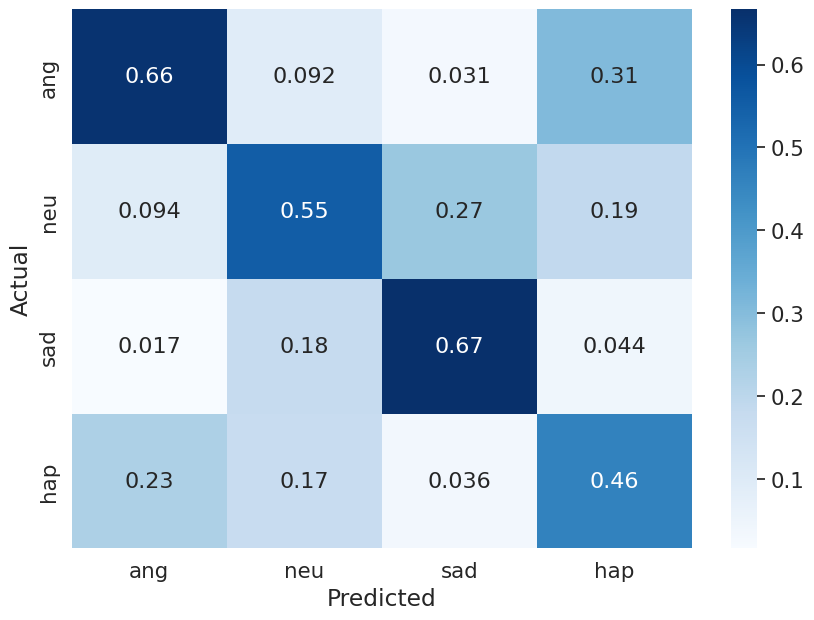

In [22]:
labels = dataset_config.target_labels
cm = cm.cpu()
a = cm / reduce(cm, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

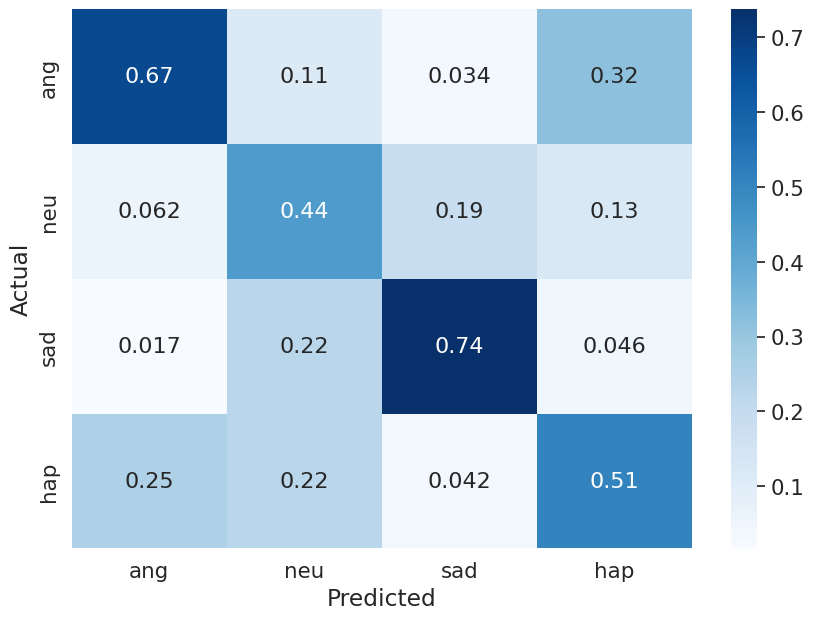

In [23]:
a = cm / reduce(cm, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [ ]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
loss_df

In [ ]:
from scipy.signal import savgol_filter

fig, axes = plt.subplots(1, 5, figsize=(14,3))
for i, c in enumerate(loss_df.columns):
    axes[i].plot(savgol_filter(loss_df[c], 301, 7))
    axes[i].set_title(c)

In [24]:
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

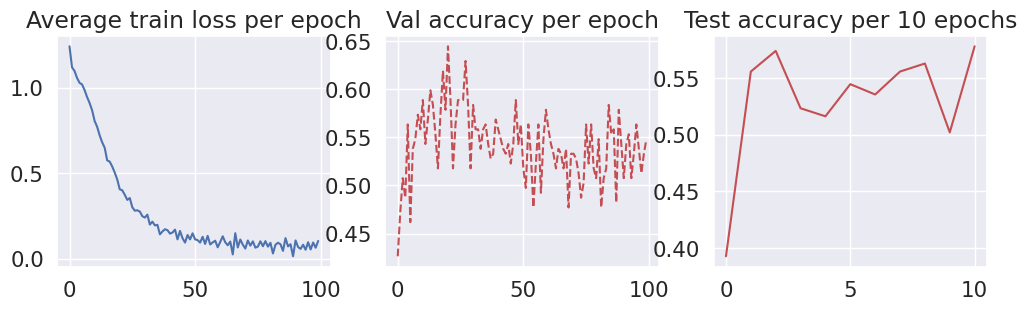

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [26]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med
}
torch.save(train_log, log_dir+"train_metrics.pt")
# loss_df.to_csv(log_dir+"train_losses.csv")

In [27]:
trainer.current_step += 1

In [29]:
trainer.load(log_dir + 'model.epoch=81.step=139887.pt')

In [30]:
metrics, metrics_details, confusion_matrix = trainer.test_step()
me = metrics.compute()
med = metrics_details.compute()
cm = confusion_matrix.compute()

Correct: 556/988 (0.5628)


In [31]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.5646, device='cuda:0'),
 'acc_weighted': tensor(0.5628, device='cuda:0'),
 'f1s_unweighted': tensor(0.5640, device='cuda:0'),
 'f1s_weighted': tensor(0.5642, device='cuda:0'),
 'rocauc': tensor(0.7988, device='cuda:0'),
 'uar': tensor(0.5646, device='cuda:0'),
 'wap': tensor(0.5719, device='cuda:0')}
{'acc_detail': tensor([0.5204, 0.5468, 0.6866, 0.5048], device='cuda:0'),
 'f1s_detail': tensor([0.5838, 0.5574, 0.6535, 0.4615], device='cuda:0'),
 'precision_detail': tensor([0.6647, 0.5684, 0.6234, 0.4251], device='cuda:0'),
 'recall_detail': tensor([0.5204, 0.5468, 0.6866, 0.5048], device='cuda:0'),
 'rocauc_detail': tensor([0.8100, 0.7485, 0.8828, 0.7540], device='cuda:0')}
tensor([[115,  29,  11,  66],
        [ 17, 187,  70,  68],
        [  4,  56, 149,   8],
        [ 37,  57,   9, 105]], device='cuda:0')


In [32]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model': 'model.epoch=81.step=139887.pt'
}
torch.save(train_log, log_dir+"train_metrics_bestUA.pt")

<Axes: xlabel='Predicted', ylabel='Actual'>

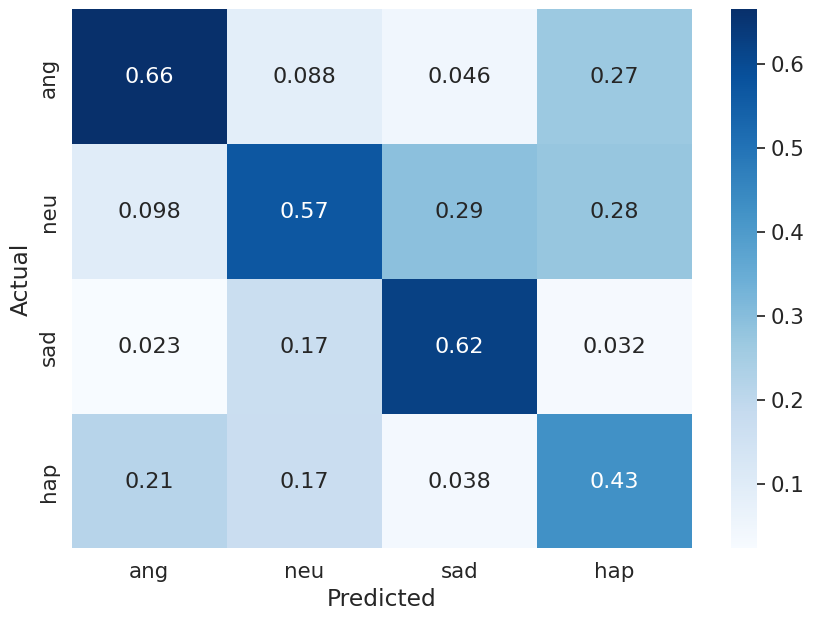

In [33]:
labels = dataset_config.target_labels
cm = cm.cpu()
a = cm / reduce(cm, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

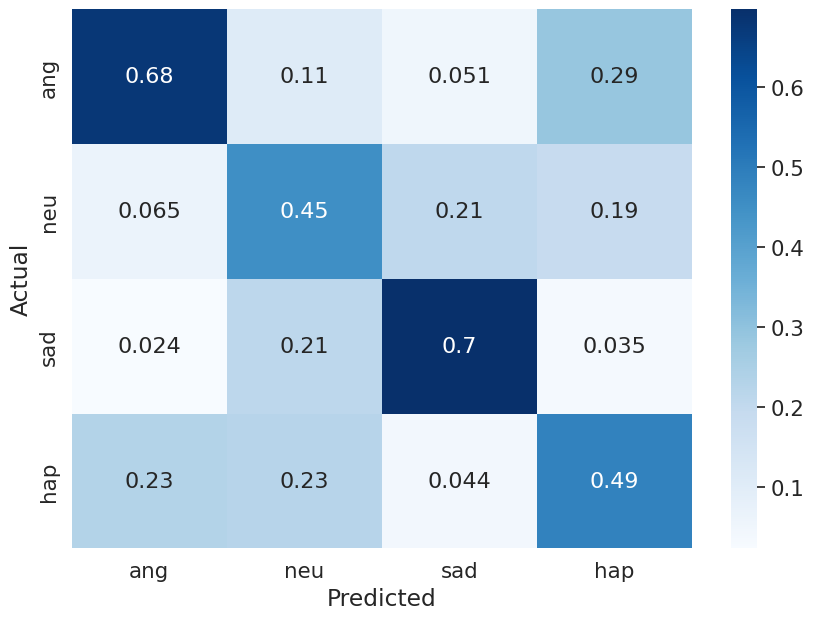

In [34]:
a = cm / reduce(cm, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size